<a href="https://colab.research.google.com/github/Brycexxx/fastai/blob/master/lesson5_sgd_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
from fastai.basics import *

In [0]:
path = Config().data_path()/'mnist'

In [0]:
path.mkdir(parents=True, exist_ok=True)

In [7]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving mnist.pkl.gz to mnist.pkl.gz
User uploaded file "mnist.pkl.gz" with length 16168813 bytes


In [0]:
! mv mnist.pkl.gz /root/.fastai/data/mnist/

In [0]:
with gzip.open(path/'mnist.pkl.gz', 'rb') as f:
  (x_train, y_train), (x_valid, y_valid), _ = pickle.load(f, encoding='latin-1')

(50000, 784)

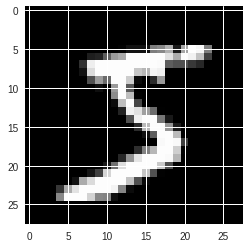

In [10]:
plt.imshow(x_train[0].reshape(28, 28), cmap='gray')
x_train.shape

In [11]:
x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid))
n, c = x_train.shape
x_train.shape, y_train.min(), y_train.max()

(torch.Size([50000, 784]), tensor(0), tensor(9))

In [0]:
bs=64
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
data = DataBunch.create(train_ds, valid_ds, bs=bs)

In [13]:
x, y = next(iter(data.train_dl))
x.shape, y.shape

(torch.Size([64, 784]), torch.Size([64]))

In [0]:
class MnistLogistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10, bias=True)

    def forward(self, xb): return self.lin(xb)

In [0]:
model = MnistLogistic().cuda()

In [163]:
model

MnistLogistic(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)

In [133]:
model.lin

Linear(in_features=784, out_features=10, bias=True)

In [134]:
model(x).shape

torch.Size([64, 10])

In [135]:
[p.shape for p in model.parameters()]

[torch.Size([10, 784]), torch.Size([10])]

In [0]:
lr = 2e-2

In [0]:
loss_func = nn.CrossEntropyLoss()

In [0]:
def update(x, y, lr):
    wd = 1e-5
    y_hat = model(x)
    w2 = .0
    for p in model.parameters(): w2 += (p**2).sum()
    loss = loss_func(y_hat, y) + wd * w2
    loss.backward()
    with torch.no_grad():
        for p in model.parameters():
            p.sub_(lr * p.grad)
            p.grad.zero_()
    return loss.item()

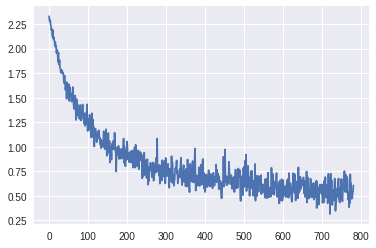

In [167]:
losses = [update(x, y, lr) for x, y in data.train_dl]
plt.plot(losses);

In [0]:
model = MnistLogistic().cuda()

In [0]:
def update_adam(x, y, lr):
    opt = optim.Adam(model.parameters(), lr)
    y_hat = model(x)
    loss = loss_func(y_hat, y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

In [0]:
losses = [update_adam(x, y, lr) for x, y in data.train_dl]

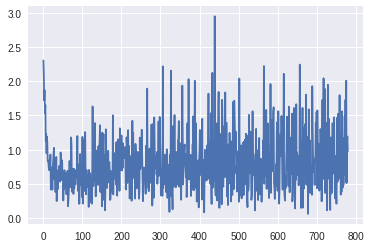

In [189]:
plt.plot(losses);

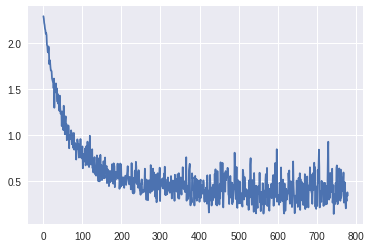

In [190]:
model = MnistLogistic().cuda()
losses = [update_adam(x, y, 1e-3) for x, y in data.train_dl]
plt.plot(losses);

In [0]:
class MnistNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(784, 50, bias=True)
        self.lin2 = nn.Linear(50, 10, bias=True)

    def forward(self, xb):
        x = self.lin1(xb)
        x = nn.functional.relu(x)
        return self.lin2(x)

In [0]:
model = MnistNN().cuda()

In [0]:
losses = [update(x, y, lr) for x, y in data.train_dl]

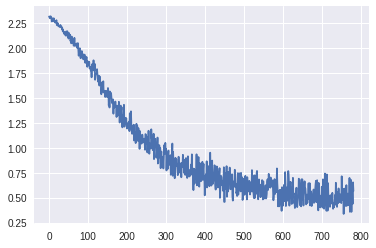

In [194]:
plt.plot(losses);

In [0]:
model = MnistNN().cuda()
losses = [update(x, y, lr) for x, y in data.train_dl for _ in range(4)]

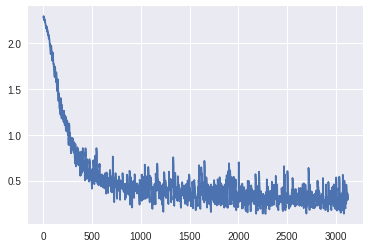

In [198]:
plt.plot(losses);

In [0]:
model = MnistNN().cuda()

In [0]:
losses = [update_adam(x, y, lr) for x, y in data.train_dl]

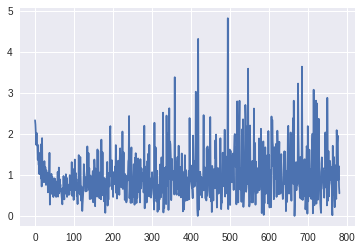

In [201]:
plt.plot(losses);

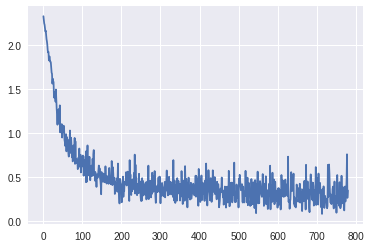

In [203]:
model = MnistNN().cuda()
losses = [update_adam(x, y, 1e-3) for x, y in data.train_dl]
plt.plot(losses);

In [0]:
def update_epoch(n=1):
    model = MnistLogistic().cuda()
    v = [torch.zeros_like(p) for p in model.parameters()]
    s = [torch.zeros_like(p) for p in model.parameters()]
    wd = 0
    losses = []
    def update(x, y, lr, beta1, beta2):
        w2 = .0
        y_hat = model(x)
        for p in model.parameters(): w2 += (p ** 2).sum()
        loss = loss_func(y_hat, y) + wd * w2
        losses.append(loss.item())
        loss.backward()
        with torch.no_grad():
            parameters = list(model.parameters())
            for i in range(len(parameters)):
                v[i] = beta1 * v[i] + (1 - beta1) * parameters[i].grad
                s[i] = beta1 * s[i] + (1 - beta2) * parameters[i].grad ** 2
                parameters[i].sub_(lr * v[i] / (torch.sqrt(s[i]+1e-8)))
                parameters[i].grad.zero_()
    for i in range(n):
        print('epoch %d start...' % i)
        for x, y in data.train_dl:
            update(x, y, 1e-3, 0.9, 0.999)
    return losses

In [208]:
losses = update_epoch()

epoch 0 start...


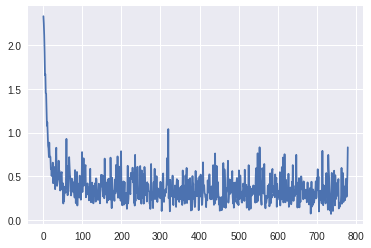

In [209]:
plt.plot(losses)

In [0]:
learn = Learner(data, MnistNN(), loss_func=loss_func, metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-02


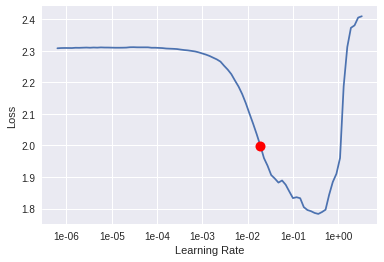

In [211]:
learn.lr_find()
learn.recorder.plot()

In [212]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy
1,0.149963,0.131664,0.962600


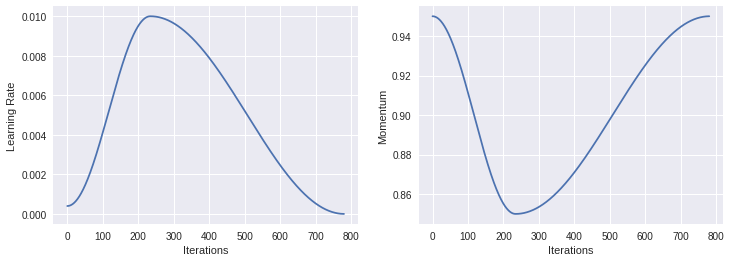

In [213]:
learn.recorder.plot_lr(show_moms=True)

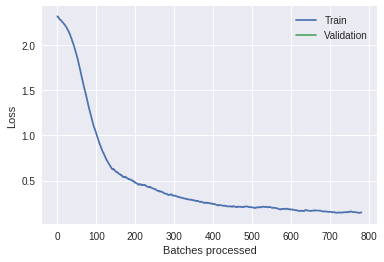

In [214]:
learn.recorder.plot_losses()